### This recipe contains the step-by-step to help you calculate and find the thermocline depth.


Based on the potential temperature depth profile, you will calculate the gradient and find the highest rate of change, which will define the depth of the thermoclone.
The data is from ROMS output, but the main idea using xroms can help you to use in your own dataset.

<br>

**Note:**
- If you want to use this recipe as it is, you will need to request access to the dataset being used. This dataset is sitting on NCI-Gadi





**Information:**
- Create by David Gwyther   
- Modified and adapted by Fernando Sobral on 27th Mar 2025


In [5]:
import matplotlib.pyplot as plt

import xroms
import numpy as np
import cmocean as cmo
from glob import glob


In [6]:
# Listing ROMS files and sorting ascending (default) by the filename's numbers

files = sorted(glob('/g/data/yj27/cgk561/freerun_1993_2023_CK/output/roms_his*.nc'))

files[:5]

['/g/data/yj27/cgk561/freerun_1993_2023_CK/output/roms_his_01461.nc',
 '/g/data/yj27/cgk561/freerun_1993_2023_CK/output/roms_his_01491.nc',
 '/g/data/yj27/cgk561/freerun_1993_2023_CK/output/roms_his_01521.nc',
 '/g/data/yj27/cgk561/freerun_1993_2023_CK/output/roms_his_01551.nc',
 '/g/data/yj27/cgk561/freerun_1993_2023_CK/output/roms_his_01581.nc']

In [ ]:
# Loading ROMS output with XROMS

# Just to avoid a warning froms xroms
import warnings
warnings.filterwarnings('ignore')

# Reading roms data. 
# This dataset consists of data output every 3h. We will use just one file (close to a month). But you can remove the index in files and use xroms.open_mfnetcdf(files) to read all the dataset (it will take a long time to finish!)
ds = xroms.open_netcdf(files[20])
roms, xgrid = xroms.roms_dataset(ds, include_cell_volume=True)


In [ ]:
# We will need the following metrics

# Calculating the time-mean for z-levels at rho-points and at w-points
roms["z_rho0"]  = roms.z_rho.mean('ocean_time').fillna(0)
roms["z_w0"]    = roms.z_w.mean(dim='ocean_time').fillna(0)

In [ ]:
# Compute mean vertical temperature gradient at s_w points.
dTdz_mean = xroms.ddz(roms.temp, xgrid, scoord='s_w', sfill_value=True).mean('ocean_time')

# Get depth at maximum gradient value in s_w dimension. 
max_s_w_idx = dTdz_mean.idxmax(dim='s_w').fillna(0)


# Selecting the depth in z level of the maximum gradient
roms["z_dtdzmax"] = roms.z_w0.sel(s_w=max_s_w_idx)

In [ ]:
# Selecting a point to be plotted below and loading the variables.

temp_p    = roms.temp.mean('ocean_time').isel(eta_rho=100,xi_rho=220).load()
zrho0_p   = roms.z_rho0.isel(eta_rho=100,xi_rho=220).load()
zw0_p     = roms.z_w0.isel(eta_rho=100,xi_rho=220).load()
dTdz_p    = dTdz_mean.isel(eta_rho=100,xi_rho=220) .load()
maxdTdz_p = roms.z_dtdzmax.isel(eta_rho=100,xi_rho=220).load()

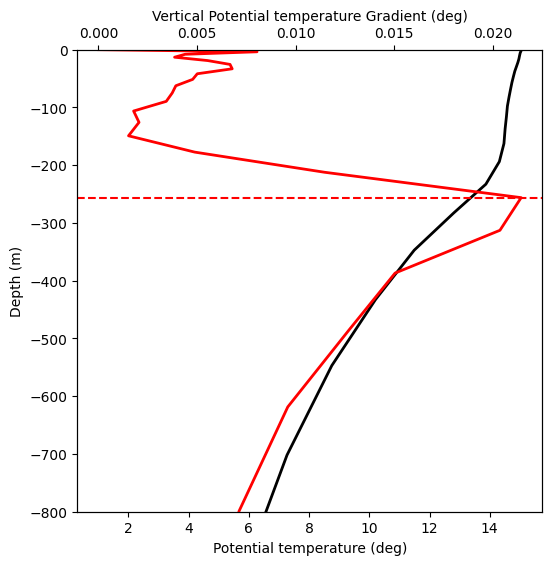

In [ ]:
# Making the plot for a single point, showing the temperature profile in black, and the vertical derivative of temperature, showing the maximum of the termocline (maximum vertical variability of temperature).

fig, ax = plt.subplots(figsize=(6, 6))

# Creating second X axis to allow to see properly different magnitudes
axx = plt.twiny(ax)


# Plotting
ax.plot(temp_p, zrho0_p, 'k', lw=2)
axx.plot(dTdz_p, zw0_p, color='r', lw=2)
axx.axhline(maxdTdz_p, color='r', linestyle='dashed')
ax.set_ylim(-800,0)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Potential temperature (deg)')
axx.set_xlabel('Vertical Potential temperature Gradient (deg)');

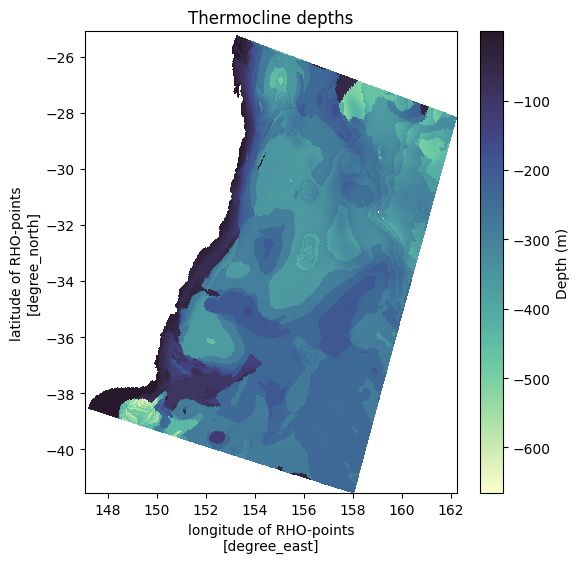

In [ ]:
# Plotting all thermocline depths, as a map.

plt.figure(figsize=(6, 6))

pt = roms.z_dtdzmax.where(~np.isnan(roms.dz0.isel(s_rho=-1))).plot(x='lon_rho', y='lat_rho', cmap=cmo.cm.deep)
plt.title('Thermocline depths')

cb = pt.colorbar
cb.set_label('Depth (m)');
